# Predicción de insufucuencia cardiaca

En este ejemplo se entrenará una red neuronal que predizca la probabilidad de que una persona sufra una insuficiencia cardiaca. Para ello, se usará el dataset ["Heart Failure Prediction Dataset"](https://www.kaggle.com/fedesoriano/heart-failure-prediction) en Kaggle y MLPClassifier de sklearn para crear la red neuronal.


El codigo creado esta basado en los ejemplos de [**towards** data science](https://towardsdatascience.com/applied-deep-learning-part-2-real-world-case-studies-1bb4b142a585).


# Paquetes

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import sklearn

from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

from __future__ import print_function
from datetime import datetime
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification, make_moons, make_circles
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, Activation
##from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, KFold
import keras.backend as K
from keras.wrappers.scikit_learn import KerasClassifier

# Funciones para Plotear


In [ ]:
def plot_decision_boundary(func, X, y, figsize=(9, 6)):
    amin, bmin = X.min(axis=0) - 0.1
    amax, bmax = X.max(axis=0) + 0.1
    hticks = np.linspace(amin, amax, 101)
    vticks = np.linspace(bmin, bmax, 101)
    
    aa, bb = np.meshgrid(hticks, vticks)
    ab = np.c_[aa.ravel(), bb.ravel()]
    c = func(ab)
    cc = c.reshape(aa.shape)

    cm = plt.cm.RdBu
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    fig, ax = plt.subplots(figsize=figsize)
    contour = plt.contourf(aa, bb, cc, cmap=cm, alpha=0.8)
    
    ax_c = fig.colorbar(contour)
    ax_c.set_label("$P(y = 1)$")
    ax_c.set_ticks([0, 0.25, 0.5, 0.75, 1])
    
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cm_bright)
    plt.xlim(amin, amax)
    plt.ylim(bmin, bmax)

def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])

    Z = model.predict_classes(np.c_[xx.ravel(), yy.ravel()], verbose=0)
    Z = Z.reshape(xx.shape)
    fig = plt.figure(figsize=(8, 8))
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
def plot_data(X, y, figsize=None):
    if not figsize:
        figsize = (8, 6)
    plt.figure(figsize=figsize)
    plt.plot(X[y==0, 0], X[y==0, 1], 'or', alpha=0.5, label=0)
    plt.plot(X[y==1, 0], X[y==1, 1], 'ob', alpha=0.5, label=1)
    plt.xlim((min(X[:, 0])-0.1, max(X[:, 0])+0.1))
    plt.ylim((min(X[:, 1])-0.1, max(X[:, 1])+0.1))
    plt.legend()

def plot_loss_accuracy(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, max(1, historydf.values.max())))
    loss = history.history['loss'][-1]
    acc = history.history['acc'][-1]
    plt.title('Loss: %.3f, Accuracy: %.3f' % (loss, acc))

def plot_loss(history):
    historydf = pd.DataFrame(history.history, index=history.epoch)
    plt.figure(figsize=(8, 6))
    historydf.plot(ylim=(0, historydf.values.max()))
    plt.title('Loss: %.3f' % history.history['loss'][-1])
    
def plot_confusion_matrix(model, X, y):
    y_pred = model.predict(X, verbose=0)
    plt.figure(figsize=(8, 6))
    sns.heatmap(pd.DataFrame(confusion_matrix(y, y_pred)), annot=True, fmt='d', cmap='YlGnBu', alpha=0.8, vmin=0)

def plot_compare_histories(history_list, name_list, plot_accuracy=True):
    dflist = []
    min_epoch = len(history_list[0].epoch)
    losses = []
    for history in history_list:
        h = {key: val for key, val in history.history.items() if not key.startswith('val_')}
        dflist.append(pd.DataFrame(h, index=history.epoch))
        min_epoch = min(min_epoch, len(history.epoch))
        losses.append(h['loss'][-1])

    historydf = pd.concat(dflist, axis=1)

    metrics = dflist[0].columns
    idx = pd.MultiIndex.from_product([name_list, metrics], names=['model', 'metric'])
    historydf.columns = idx
    
    plt.figure(figsize=(6, 8))

    ax = plt.subplot(211)
    historydf.xs('loss', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
    plt.title("Training Loss: " + ' vs '.join([str(round(x, 3)) for x in losses]))
    
    if plot_accuracy:
        ax = plt.subplot(212)
        historydf.xs('acc', axis=1, level='metric').plot(ylim=(0,1), ax=ax)
        plt.title("Accuracy")
        plt.xlabel("Epochs")
    
    plt.xlim(0, min_epoch-1)
    plt.tight_layout()
    
def make_sine_wave():
    c = 3
    num = 2400
    step = num/(c*4)
    np.random.seed(0)
    x0 = np.linspace(-c*np.pi, c*np.pi, num)
    x1 = np.sin(x0)
    noise = np.random.normal(0, 0.1, num) + 0.1
    noise = np.sign(x1) * np.abs(noise)
    x1  = x1 + noise
    x0 = x0 + (np.asarray(range(num)) / step) * 0.3
    X = np.column_stack((x0, x1))
    y = np.asarray([int((i/step)%2==1) for i in range(len(x0))])
    return X, y

def make_multiclass(N=500, D=2, K=3):
    """
    N: number of points per class
    D: dimensionality
    K: number of classes
    """
    np.random.seed(0)
    X = np.zeros((N*K, D))
    y = np.zeros(N*K)
    for j in range(K):
        ix = range(N*j, N*(j+1))
        # radius
        r = np.linspace(0.0,1,N)
        # theta
        t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        y[ix] = j
    fig = plt.figure(figsize=(6, 6))
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu, alpha=0.8)
    plt.xlim([-1,1])
    plt.ylim([-1,1])
    return X, y

# Previsualización de Datos y Preprocesamiento

Antes de crear la red neuronal se deben poner los datos (características) en una forma que puedan leerse, para ello se pasara la información a un dataframe de pandas. Luego, se normalizan los datos que trabajan en rangos muy grandes y se representan los datos categoricos como *one-hot*.

In [ ]:
raw_df = pd.read_csv('drive/MyDrive/10° Semestre/Machine Learning/Clase U6/Codigo/heart.csv') 
raw_df.head()

Age Sex ChestPainType  RestingBP  Cholesterol  FastingBS RestingECG  MaxHR  \
0   40   M           ATA        140          289          0     Normal    172   
1   49   F           NAP        160          180          0     Normal    156   
2   37   M           ATA        130          283          0         ST     98   
3   48   F           ASY        138          214          0     Normal    108   
4   54   M           NAP        150          195          0     Normal    122   

  ExerciseAngina  Oldpeak ST_Slope  HeartDisease  
0              N     0.00       Up             0  
1              N     1.00     Flat             1  
2              N     0.00       Up             0  
3              Y     1.50     Flat             1  
4              N     0.00       Up             0

Se comprueba que no hayan valores nulos:

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


Se muestra distinta información sobre los datos:

In [ ]:
raw_df.describe()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease
count 918.00     918.00       918.00     918.00 918.00   918.00        918.00
mean   53.51     132.40       198.80       0.23 136.81     0.89          0.55
std     9.43      18.51       109.38       0.42  25.46     1.07          0.50
min    28.00       0.00         0.00       0.00  60.00    -2.60          0.00
25%    47.00     120.00       173.25       0.00 120.00     0.00          0.00
50%    54.00     130.00       223.00       0.00 138.00     0.60          1.00
75%    60.00     140.00       267.00       0.00 156.00     1.50          1.00
max    77.00     200.00       603.00       1.00 202.00     6.20          1.00

Se muestra la correlación entre todas las caracteristicas:

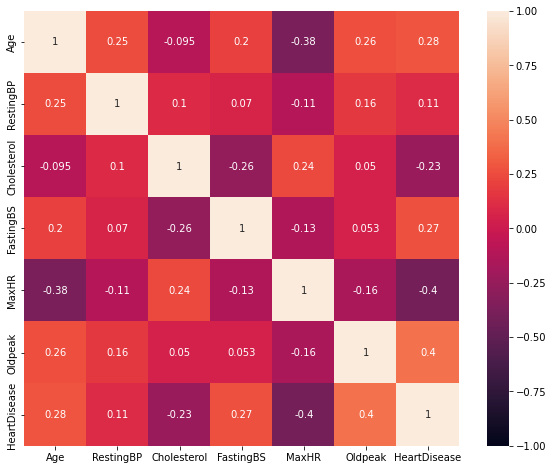

In [ ]:
plt.figure(figsize=(10 ,8))
sns.heatmap(raw_df.corr(), annot = True, square = True, vmin = -1, vmax = 1)

Se procede a normalizar las caracteristicas. 

Primero, se muestran estos datos en graficos de barras:

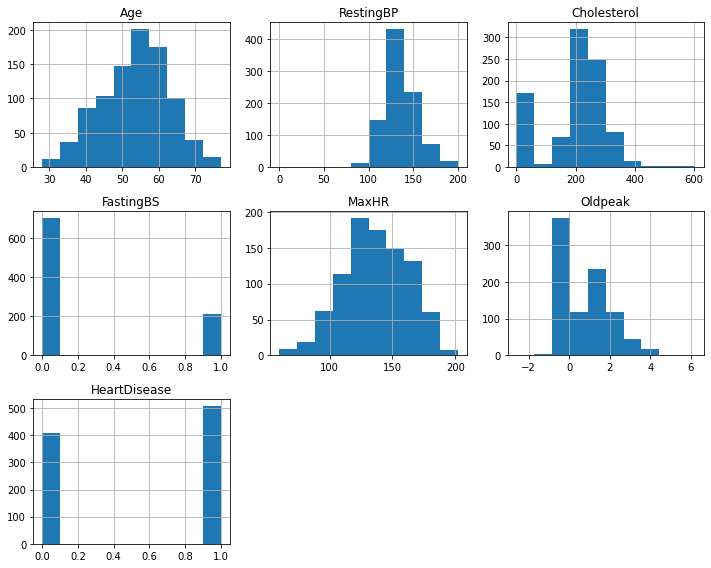

In [ ]:
raw_df.hist(figsize=(10 ,8))
plt.tight_layout()

Se normalizarán todos estos, menos "FastingBS" y "HeartDisease":

In [ ]:
df = raw_df.copy()

ss= StandardScaler()
scale_features = ['Age','RestingBP','Cholesterol','MaxHR','Oldpeak']
df[scale_features] = ss.fit_transform(df[scale_features])

Se transforman las variables categoricas a *one-hot*:

In [ ]:
categorical_features = ['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina','ST_Slope']
df_cat = pd.get_dummies(df[categorical_features])
df = df.drop(categorical_features, axis = 1)
df = pd.concat([df,df_cat], axis = 1)
df.head()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
0 -1.43       0.41         0.83          0   1.38    -0.83             0   
1 -0.48       1.49        -0.17          0   0.75     0.11             1   
2 -1.75      -0.13         0.77          0  -1.53    -0.83             0   
3 -0.58       0.30         0.14          0  -1.13     0.57             1   
4  0.05       0.95        -0.03          0  -0.58    -0.83             0   

   Sex_F  Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
0      0      1                  0                  1                  0   
1      1      0                  0                  0                  1   
2      0      1                  0                  1                  0   
3      1      0                  1                  0                  0   
4      0      1                  0                  0                  1   

   ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
0                 0               0                  1              0   
1                 0               0                  1              0   
2                 0               0                  0              1   
3                 0               0                  1              0   
4                 0               0                  1              0   

   ExerciseAngina_N  ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  \
0                 1                 0              0              0   
1                 1                 0              0              1   
2                 1                 0              0              0   
3                 0                 1              0              1   
4                 1                 0              0              0   

   ST_Slope_Up  
0            1  
1            0  
2            1  
3            0  
4            1

In [ ]:
df.describe()

Age  RestingBP  Cholesterol  FastingBS  MaxHR  Oldpeak  HeartDisease  \
count 918.00     918.00       918.00     918.00 918.00   918.00        918.00   
mean   -0.00       0.00        -0.00       0.23   0.00    -0.00          0.55   
std     1.00       1.00         1.00       0.42   1.00     1.00          0.50   
min    -2.71      -7.15        -1.82       0.00  -3.02    -3.27          0.00   
25%    -0.69      -0.67        -0.23       0.00  -0.66    -0.83          0.00   
50%     0.05      -0.13         0.22       0.00   0.05    -0.27          1.00   
75%     0.69       0.41         0.62       0.00   0.75     0.57          1.00   
max     2.49       3.65         3.70       1.00   2.56     4.98          1.00   

       Sex_F  Sex_M  ChestPainType_ASY  ChestPainType_ATA  ChestPainType_NAP  \
count 918.00 918.00             918.00             918.00             918.00   
mean    0.21   0.79               0.54               0.19               0.22   
std     0.41   0.41               0.50               0.39               0.42   
min     0.00   0.00               0.00               0.00               0.00   
25%     0.00   1.00               0.00               0.00               0.00   
50%     0.00   1.00               1.00               0.00               0.00   
75%     0.00   1.00               1.00               0.00               0.00   
max     1.00   1.00               1.00               1.00               1.00   

       ChestPainType_TA  RestingECG_LVH  RestingECG_Normal  RestingECG_ST  \
count            918.00          918.00             918.00         918.00   
mean               0.05            0.20               0.60           0.19   
std                0.22            0.40               0.49           0.40   
min                0.00            0.00               0.00           0.00   
25%                0.00            0.00               0.00           0.00   
50%                0.00            0.00               1.00           0.00   
75%                0.00            0.00               1.00           0.00   
max                1.00            1.00               1.00           1.00   

       ExerciseAngina_N  ExerciseAngina_Y  ST_Slope_Down  ST_Slope_Flat  \
count            918.00            918.00         918.00         918.00   
mean               0.60              0.40           0.07           0.50   
std                0.49              0.49           0.25           0.50   
min                0.00              0.00           0.00           0.00   
25%                0.00              0.00           0.00           0.00   
50%                1.00              0.00           0.00           1.00   
75%                1.00              1.00           0.00           1.00   
max                1.00              1.00           1.00           1.00   

       ST_Slope_Up  
count       918.00  
mean          0.43  
std           0.50  
min           0.00  
25%           0.00  
50%           0.00  
75%           1.00  
max           1.00

# Red Neuronal

Ahora se procede a crear la red neuronal que predicirá si una persona tendrá una insuficiencia cardiaca.

Primero, se separa el dataset entre valores de entrenamiento y de testeo.

In [ ]:
X = df.drop('HeartDisease', axis = 1).values
y = df['HeartDisease'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(642, 20) (642,) (276, 20) (276,)


Se crea un modelo con tres capas ocultas ReLU, las dos primeras de ancho 64 y la otra 2, y una salida sigmoidea:

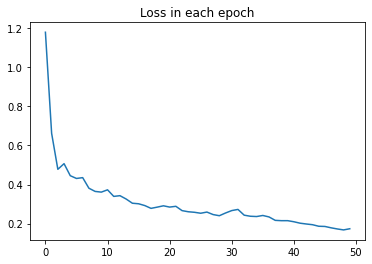

Precisión en el set de practica: 0.950156
Precisión en el set de prueba: 0.833333


In [ ]:
mlp = MLPClassifier(hidden_layer_sizes=(64, 64,2), activation='relu', max_iter=50, alpha=1e-4,
                    solver='adam', verbose=0, tol=1e-4, random_state=1,
                    learning_rate_init=.1)
mlp.fit(X_train, y_train)

plt.plot(mlp.loss_curve_)
plt.title('Loss in each epoch')
plt.show()

print("Precisión en el set de practica: %f" % mlp.score(X_train, y_train))
print("Precisión en el set de prueba: %f" % mlp.score(X_test, y_test))

Finalmente, se obtiene su matriz de confusión:

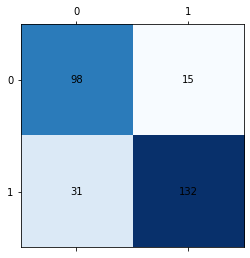

In [ ]:
y_pred = mlp.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
plt.matshow(cm, cmap=plt.cm.Blues)

for i in range(2):
    for j in range(2):
        c = cm[j,i]
        plt.text(i, j, str(c), va='center', ha='center')